**Spam Classification with BERT**

The aim of this project is a spam detection to get a model to predict if the messages is spam or not. This approach i have used a BERT (Bidirectional Encoder Representations from Transformers) model to gain our model. In analysis i have used a Huggingface Transformers library as well.

**Dataset**

The dataset comes from SMS Spam Collection and that can be found at
https://www.kaggle.com/uciml/sms-spam-collection-dataset.

This SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It comprises one set of SMS messages in English of 5,574 messages, which is tagged acording being ham (legitimate) or spam.

In [1]:
!pip install transformers

**Importing the required libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from keras.models import Model

import transformers
from transformers import BertTokenizer, TFBertModel

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**First observations:**

In [4]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df.shape

(5572, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB



### **Data preparation**

Remove unnecessary variables:


In [7]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)

Rename columns:

In [8]:
df.rename(columns={'v1': 'Class', 'v2': 'Text'}, inplace=True)

In [9]:
df.head()

,Class,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


We change column "Class" to 0 and 1:

- spam = 1
- ham = 0



In [10]:
df['Class'] = df['Class'].map({'ham':0, 'spam':1})
df.head()

,Class,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
df['Text'][2]

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

In [12]:
# Checking for any missing values
df.isna().sum()

Class    0
Text     0
dtype: int64

### **EDA and Data Visualization**

We check proportion Class variable:

In [13]:
df['Class'].value_counts()

Class
0    4825
1     747
Name: count, dtype: int64

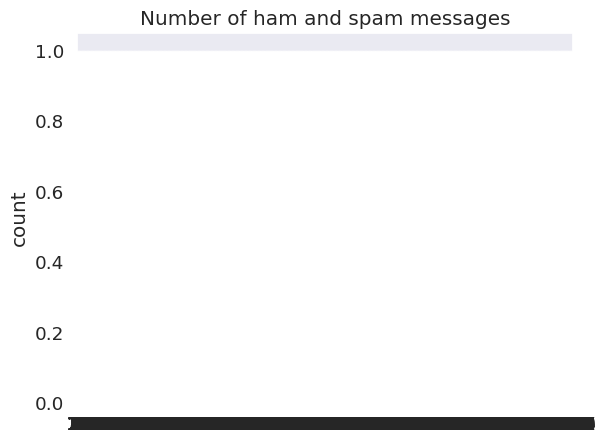

In [14]:
sns.set(style = "darkgrid" , font_scale = 1.2)
sns.countplot(df.Class).set_title("Number of ham and spam messages")
plt.show()

In [15]:
df.describe()

,Class
count,5572.000000
mean,0.134063
std,0.340751
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


The target class variable is imbalanced, where "ham" values are more dominating than "spam" ones.

**SMS Distribution**

Now we check the percentage of spam SMS and ham SMS messages:

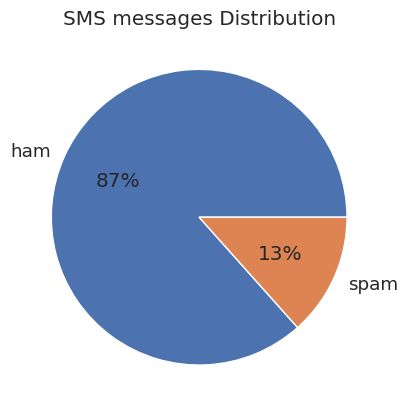

In [16]:
sms = pd.value_counts(df["Class"], sort=True)
sms.plot(kind="pie", labels=["ham", "spam"], autopct="%1.0f%%")

plt.title("SMS messages Distribution")
plt.ylabel("")
plt.show()

Above 87% of these SMS  messages are ham (legitimate) and 13% of them are spam.


Length of text messages:

In [17]:
df['length'] = df.Text.apply(len)
df.head()

,Class,Text,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


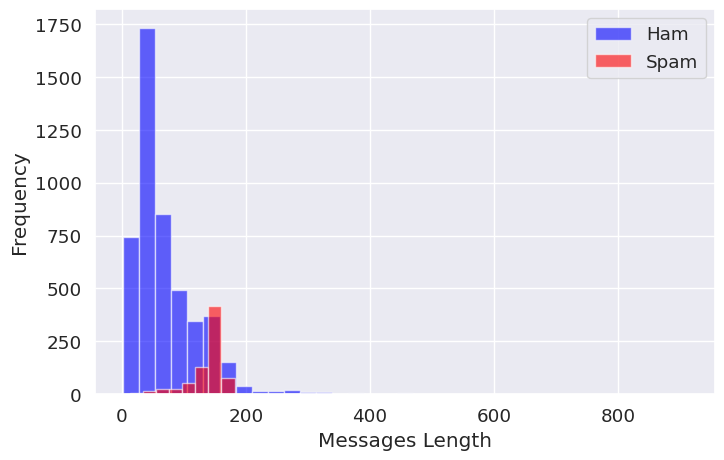

In [18]:
plt.figure(figsize=(8, 5))
df[df.Class == 0].length.plot(bins=35, kind='hist', color='blue', label='Ham', alpha=0.6)
df[df.Class == 1].length.plot(kind='hist', color='red', label='Spam', alpha=0.6)
plt.legend()
plt.xlabel("Messages Length");

Now let's see if the length has an influence on messages spam or ham:

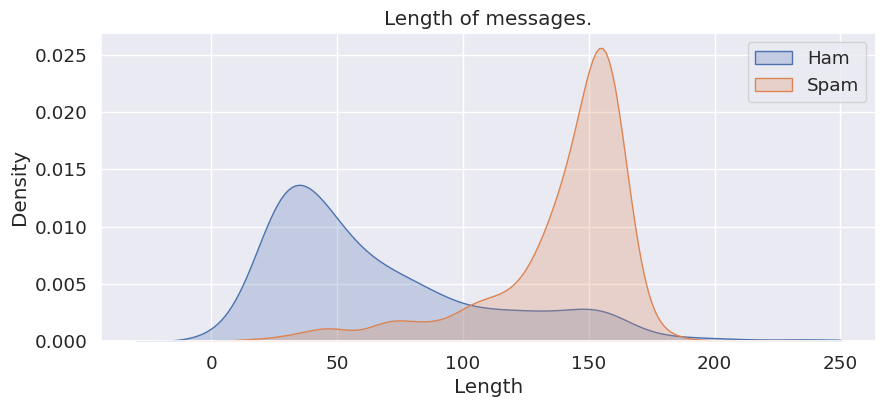

In [19]:
_, ax = plt.subplots(figsize=(10, 4))
sns.kdeplot(df.loc[df.Class == 0, "length"], shade=True, label="Ham", clip=(-50, 250),)
sns.kdeplot(df.loc[df.Class == 1, "length"], shade=True, label="Spam")
ax.set(
    xlabel="Length",
    ylabel="Density",
    title="Length of messages.",
)
ax.legend(loc="upper right")
plt.show()

As we can notice the spam messages are longer than ham ones (that is normal due to the number of words) and  have around 150 characters.

### **Text Pre-processing**

In the next step we clean text, remove stop words and apply stemming operation for each line of text:


In [20]:
stop_words = stopwords.words('english')
print(stop_words[::10])

porter = PorterStemmer()

['i', "you've", 'himself', 'they', 'that', 'been', 'a', 'while', 'through', 'in', 'here', 'few', 'own', 'just', 're', 'doesn', 'ma', "shouldn't"]


In [21]:
def clean_text(words):
    """The function to clean text"""
    words = re.sub("[^a-zA-Z]"," ", words)
    text = words.lower().split()
    return " ".join(text)

def remove_stopwords(text):
    """The function to removing stopwords"""
    text = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return " ".join(text)

def stemmer(stem_text):
    """The function to apply stemming"""
    stem_text = [porter.stem(word) for word in stem_text.split()]
    return " ".join(stem_text)

In [22]:
df['Text'] = df['Text'].apply(clean_text)
df['Text'] = df['Text'].apply(remove_stopwords)
df['Text'] = df['Text'].apply(stemmer)

In [23]:
df.head()

,Class,Text,length
0,0,go jurong point crazi avail bugi n great world...,111
1,0,ok lar joke wif u oni,29
2,1,free entri wkli comp win fa cup final tkt st m...,155
3,0,u dun say earli hor u c alreadi say,49
4,0,nah think goe usf live around though,61


In [24]:
print(df['Text'].apply(lambda x: len(x.split(' '))).sum())

49940


### **BERT model**

BERT (Bidirectional Encoder Representations from Transformers) is a pretrained NLP algorithm devolped by google AI. BERT is a bidirectionally trained of Transformer a popular attention model, use to language modelling. So it can have a deeper sense of language context and flow compared to the single-direction language models. BERT model instead of predicting the next word in a sequence makes use of a novel technique called Masked LM (MLM). It relies on randomly masks words in the sentence and then it tries to predict them. Unlike the previous language models, it takes both the previous and next tokens into account at the same time. This is a contrast to previous LSTM based models combined a text sequence left-to-right and right-to-left.

In the first step we have to make tokenization on our dataset. Tokenization will allow us to feed batches of sequences into the model at the same time.

To do the tokenization of our datasets we have to choose  a pre-trained model. We load the basic model (`bert-large-uncased`) from the Huggingface Transformers library.

In [25]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
tokenizer

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

BertTokenizer(name_or_path='bert-large-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

Now we have to load BERT model. In the Transformers library is avaliable many different BERT models. We use the „TFBertModel”  model (bert-base-uncased) from the library.

In [26]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Spliting the data into train and test sets:

In [27]:
X = df['Text']
y = df['Class']

In [28]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

The function which allows to encode our dataset with BERT tokenizer. We have decided on a maximum sentence length is 64 (maxlen).


In [29]:
def encode(text, maxlen):
  input_ids=[]
  attention_masks=[]

  for row in text:
    encoded = tokenizer.encode_plus(
        row,
        add_special_tokens=True,
        max_length=maxlen,
        pad_to_max_length=True,
        return_attention_mask=True,
    )
    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])

  return np.array(input_ids),np.array(attention_masks)


Based on this  encodings for our training and testing datasets are generated as follows:

In [30]:
X_train_input_ids, X_train_attention_masks = encode(X_train.values, maxlen=64)
X_test_input_ids, X_test_attention_masks = encode(X_test.values, maxlen=64)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


#### **Build the model**

We create a model using BERT model and then add two Dense layers with Dropout layer.

In [34]:
def build_model(bert_model):
   input_word_ids = tf.keras.Input(shape=(64,),dtype='int32')
   attention_masks = tf.keras.Input(shape=(64,),dtype='int32')

   # Convert KerasTensors to TensorFlow Tensors
   input_word_ids_tensor = tf.convert_to_tensor(input_word_ids)
   attention_masks_tensor = tf.convert_to_tensor(attention_masks)

   sequence_output = bert_model([input_word_ids_tensor,attention_masks_tensor]) # Pass TensorFlow Tensors to bert_model
   output = sequence_output[1]
   output = tf.keras.layers.Dense(32,activation='relu')(output)
   output = tf.keras.layers.Dropout(0.2)(output)
   output = tf.keras.layers.Dense(1,activation='sigmoid')(output)

   model = tf.keras.models.Model(inputs = [input_word_ids,attention_masks], outputs = output)
   model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy']) # Use tf.keras.optimizers.Adam

   return model

In [35]:
model = build_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 tf.convert_to_tensor (TFOp  (None, 64)                   0         ['input_1[0][0]']             
 Lambda)                                                                                          
                                                                                                  
 tf.convert_to_tensor_1 (TF  (None, 64)                   0         ['input_2[0][0]']         

We set class weights for the loss function to adjust for class imbalance. 'Spam' variable is set to weight 8x more.

We train the model for 5 epoch:

In [36]:
class_weight = {0: 1, 1: 8}

In [37]:
history = model.fit(
    [X_train_input_ids, X_train_attention_masks],
    y_train,
    batch_size=32,
    epochs=5,
    validation_data=([X_test_input_ids, X_test_attention_masks], y_test),
    class_weight=class_weight)

Epoch 1/5
140/140 [==============================] - 141s 495ms/step - loss: 1.4508 - accuracy: 0.2708 - val_loss: 0.7251 - val_accuracy: 0.1489
Epoch 2/5
140/140 [==============================] - 60s 427ms/step - loss: 1.3197 - accuracy: 0.1304 - val_loss: 0.7147 - val_accuracy: 0.1489
Epoch 3/5
140/140 [==============================] - 60s 427ms/step - loss: 1.3203 - accuracy: 0.1304 - val_loss: 0.7355 - val_accuracy: 0.1489
Epoch 4/5
140/140 [==============================] - 60s 427ms/step - loss: 1.3224 - accuracy: 0.1304 - val_loss: 0.7378 - val_accuracy: 0.1489
Epoch 5/5
140/140 [==============================] - 60s 427ms/step - loss: 1.3194 - accuracy: 0.1304 - val_loss: 0.7704 - val_accuracy: 0.1489


Visualization of training:

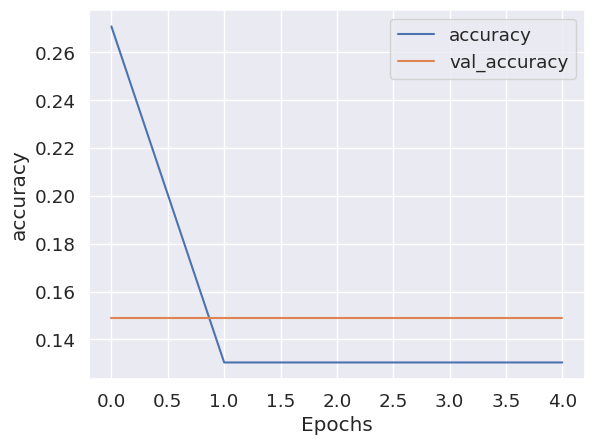

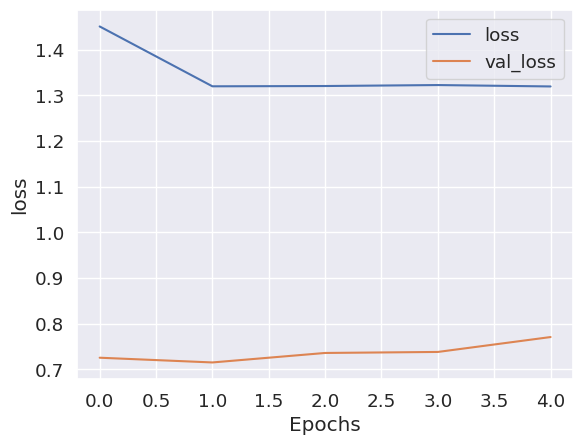

In [38]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Predictions on a test set:

In [39]:
loss, accuracy = model.evaluate([X_test_input_ids, X_test_attention_masks], y_test)
print('Test accuracy :', accuracy)

35/35 [==============================] - 5s 137ms/step - loss: 0.7704 - accuracy: 0.982959
Test accuracy : 0.9829596281051636


In [40]:
#save model
model.save_weights('bert_model')

### **Summary**

For our analysis we used a pretrained BERT model to resolve our classification problem.  After trained model we achieved an accuracy on the test set equal to 98 % and it is a very good result in comparison to previous Machine Learning models that we have used (e.g. Logistic Regression).
